In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds



def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [4]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [5]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [38]:
case=2
a = 5
b = 3
cost='l21'
H_au, A_au, T_au, Hs, As, Ts, HATs, costs= learn_HAT_adagrad(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known = static_au, T_known = np.ones(12).reshape(-1, 1))

In [9]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse
from common import compute_rmse_fraction


In [47]:
method = '1'
algo = '2'
static_fac = '3'
random_seed = 4
name = "pred_{}_{}_{}_{}".format(method, algo, static_fac, random_seed)
print (name)

pred_1_2_3_4


In [49]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [52]:
from common import compute_rmse_fraction
out = {}
for method in ['normal']:
    out[method] = {}
    for algo in ['gd']:
        out[method][algo] = {}
        for static_fac in ['static', 'None']:
            out[method][algo][static_fac] = {}
            for lam in [0]:
                out[method][algo][static_fac][lam] = load_obj("pred_static/pred_" + method
                                                                             + "_" + algo 
                                                                             + "_" + static_fac
                                                                             + "_" + str(lam))


In [55]:
n_splits = 10

pred = {}
for method in ['normal', 'transfer']:
    pred[method] = {}
    for static in ['with', 'without']:
        pred[method][static] = {}
        for random_seed in range(5):
            pred[method][static][random_seed] = {}
            for appliance in APPLIANCES_ORDER:
                pred[method][static][random_seed][appliance] = {f:[] for f in range(10, 110, 40)}

kf = KFold(n_splits=n_splits)

for random_seed in range(5):
    np.random.seed(random_seed)
    print ("random_seed:", random_seed)
    for train_percentage in range(10, 110, 10):
        print ("train_percentage:", train_percentage)
        rd = 0
        for train_max, test in kf.split(sd_df):
            print ("rd:", rd)
            rd += 1

            num_train = int((train_percentage*len(train_max)/100)+0.5)
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0)
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]

            num_test = len(test_ix)
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            print train_ix
            print test_ix
            
#             ####################################################
#             # Normal learning with static factors
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN

#             H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, H_known = static_sd[np.concatenate([test, train])], T_known = np.ones(12).reshape(-1, 1))

#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred['normal']['with'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
             
            ####################################################
            # Normal learning without static factors
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN

#             H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, T_known = np.ones(12).reshape(-1, 1))

#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred['normal']['without'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
             
            
#             ####################################################
#             # Transfer learning with static factors
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN

#             H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, H_known = static_sd[np.concatenate([test, train])], A_known=A_au, T_known = np.ones(12).reshape(-1, 1))

#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred['transfer']['with'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
             
#             ####################################################
#             # Transfer learning without static factors
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN

#             H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, A_known=A_au, T_known = np.ones(12).reshape(-1, 1))

#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred['transfer']['without'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

('random_seed:', 0)
('train_percentage:', 10)
('rd:', 0)
Int64Index([9775, 2354, 1524], dtype='int64')
Int64Index([54, 203, 527, 1450], dtype='int64')
('rd:', 1)
Int64Index([9612, 5909, 6497], dtype='int64')
Int64Index([1524, 1731, 2031, 2354], dtype='int64')
('rd:', 2)
Int64Index([5909, 54, 8574], dtype='int64')
Int64Index([2606, 3687, 3864, 3938], dtype='int64')
('rd:', 3)
Int64Index([1450, 9213, 54], dtype='int64')
Int64Index([4083, 4095, 4329, 4495], dtype='int64')
('rd:', 4)
Int64Index([54, 9612, 6268], dtype='int64')
Int64Index([4761, 4934, 5909, 5938], dtype='int64')
('rd:', 5)
Int64Index([7639, 4761, 3938], dtype='int64')
Int64Index([6268, 6377, 6429, 6497], dtype='int64')
('rd:', 6)
Int64Index([4083, 1450, 5909], dtype='int64')
Int64Index([6547, 7062, 7114, 7409], dtype='int64')
('rd:', 7)
Int64Index([9836, 7114, 1450], dtype='int64')
Int64Index([7639, 8061, 8342, 8574], dtype='int64')
('rd:', 8)
Int64Index([8342, 1450, 7062], dtype='int64')
Int64Index([8733, 9213, 9370, 9585]

In [30]:
out = {}

for method in ['normal', 'transfer']:
    out[method] = {}
    for static in ['with', 'without']:
        out[method][static] = {}
        for random_seed in range(5):
            out[method][static][random_seed] = {}   
            for appliance in APPLIANCES_ORDER[1:]:
                out[method][static][random_seed][appliance] = {}
                for f in range(10,110,10):
                    s = pd.concat(pred[method][static][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out[method][static][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out[method][static][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [31]:
mean_out = {}
for method  in ['normal', 'transfer']:
    mean_out[method] = {}
    for static in ['with', 'without']:
        mean_out[method][static] = pd.Panel(out[method][static]).mean(axis=0)


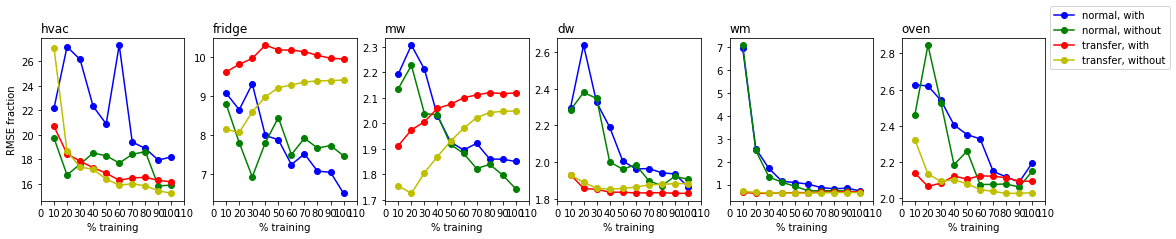

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out['normal']['with'][appliance]
    df2 = mean_out['normal']['without'][appliance]
    df3 = mean_out['transfer']['with'][appliance]
    df4 = mean_out['transfer']['without'][appliance]
    df = pd.concat([df1, df2, df3, df4], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')

ax[count-1].legend(["normal, with", 'normal, without', 'transfer, with', 'transfer, without'], loc='center left' , bbox_to_anchor=(1, 1))
plt.savefig("./analysis/0720/with_without_static_adagrad.pdf", bbox_inches="tight", dpi=300, format='pdf')